In [1]:
import datasets
import evaluate
import ollama
import sklearn
import tqdm
import transformers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils

In [2]:
# Reload last trained chechpoint.
# I did not bother saving the model explicitly and this is the last checkpint, 
# which, coincidentally, has the best train/validation loss.
model_name = 'C:/Users/raven/models/finetuned-nllb/checkpoint-22352'

In [3]:
# Load tokenizer and model and move model to GPU.
# The "mistral regex error" can be ignored, as we're not using a mistral-tokenizer.
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_name).to('cuda')

The tokenizer you are loading from 'C:/Users/raven/models/finetuned-nllb/checkpoint-22352' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [4]:
# The dataset is hosted on the Hub; no local files are needed.
# It contains two fields: "la" (latin) and "en" (english).
# This repo already has a train/test/valid split.
ds = datasets.load_dataset("grosenthal/latin_english_translation")

In [5]:
# To save time, let's generate translations for 128 examples only.
translated = {'tgt': [], 'pred': [], 'orig': []}

for i in tqdm.tqdm(np.random.choice(len(ds['test']), 128)):
    pred = utils.translate_en_lat(ds['test'][i]['en'], tokenizer, model)
    tgt = ds['test'][i]['la']
    translated['tgt'].append(tgt)
    translated['pred'].append(pred)
    translated['orig'].append(ds['test'][i]['en'])

100%|██████████| 128/128 [01:28<00:00,  1.45it/s]


In [6]:
# Create traditional tranlation quality metrics.
bleu      = evaluate.load("bleu")         # classic NLTK‑style BLEU
sacrebleu = evaluate.load("sacrebleu")    # SacreBLEU
chrf      = evaluate.load("chrf")         # character‑level F‑score
ter       = evaluate.load("ter")          # Translation Edit Rate
meteor    = evaluate.load("meteor")       # METEOR

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raven\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\raven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\raven\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
references = [[ref] for ref in translated["tgt"]]   # evaluate expects List[List[str]]
hypotheses = translated["pred"]

results = {}

# Classic BLEU (up to 4‑gram)
results["bleu"] = bleu.compute(predictions=hypotheses,
                               references=references)["bleu"]

# SacreBLEU (default is case‑insensitive, tokenised like WMT)
results["sacrebleu"] = sacrebleu.compute(predictions=hypotheses,
                                         references=references)["score"]

# chrF (default beta=2, word‑order insensitive)
results["chrF"] = chrf.compute(predictions=hypotheses,
                               references=references)["score"]

# TER (lower is better)
results["TER"] = ter.compute(predictions=hypotheses,
                             references=references)["score"]

# METEOR (requires Java; will raise if not installed)
try:
    results["METEOR"] = meteor.compute(predictions=hypotheses,
                                      references=references)["meteor"]
except Exception as e:
    results["METEOR"] = f"METEOR unavailable ({e})"

print(results)

{'bleu': 0.1249469392479946, 'sacrebleu': 12.49469392479946, 'chrF': 46.40480939849029, 'TER': 77.35059002664636, 'METEOR': np.float64(0.3955526480481845)}


The metrics above are truly not impressive.

However, human review suggests that the translations are not actually bad.

Let's back-translate with deepseek-r1 (caveats here obviously) and measure how the original english holds up against the English -> Latin -> English texts. Every translation step adds more noise to the text, so observing sentence similarities may give another indication of the translation quality.

The resoning is, if English -> Latin is actually better than what BLEU and co suggest, that a very large model should be able to resonstruct from Latin -> English a sentence that is very similar to the input English sentence. This is an automated approach to human-expert review.

In [8]:
# Simple prompt to translate from Latin to English.
# I just hope deepseek-r1 is proficient enough in Latin for this to work.
back_translated = []
for pred in tqdm.tqdm(translated['pred']):
  content = ollama.chat(
    model='deepseek-r1:8b',
    messages=[
      {'role': 'system', 'content': 'Translate the user\'s text from Latin to English. Only output the translation and stop outputting immediately after that.'},
      {'role': 'user', 'content': pred}
    ],
    think=False,
  )['message']['content']
  back_translated.append(content)

  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [01:10<00:00,  1.83it/s]


In [9]:
# Embed back-translated English sentences and the input English sentences.
backtranslated_emb = ollama.embed(
  model='embeddinggemma',
  input=back_translated
)

original_emb = ollama.embed(
  model='embeddinggemma',
  input=translated['orig']
)

In [10]:
# We can do cosing here, as embeddinggemma outputs normalized vectors, so this will yield reasonable values.
similarity = sklearn.metrics.pairwise.cosine_similarity(np.array(backtranslated_emb['embeddings']), np.array(original_emb['embeddings']))

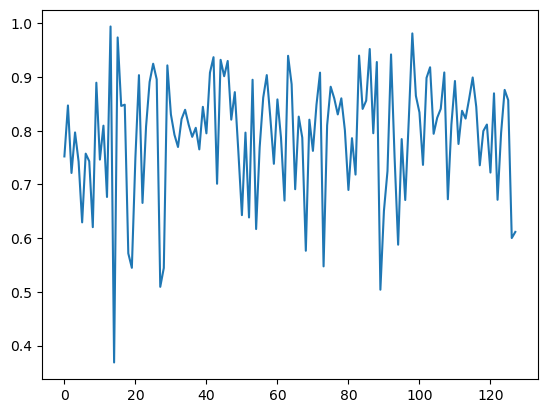

In [11]:
# Not a nice plot, but will do.
plt.plot(np.diag(similarity))

In [12]:
# Too lazy to compute all myself, let's ask pandas for a summary of the similarities.
pd.Series(np.diag(similarity)).describe()

count    128.000000
mean       0.791074
std        0.113598
min        0.368684
25%        0.737855
50%        0.810520
75%        0.865963
max        0.993893
dtype: float64

In [13]:
# This is almost surely nonsense - except if embeddinggemma
# can actually embed Latin texts, but let's do it anyway.
# Same as above, except that I embed the translated Latin text and
# the target Latin sentences.
latin_pred_emb = ollama.embed(
  model='embeddinggemma',
  input=translated['pred']
)

latin_emb = ollama.embed(
  model='embeddinggemma',
  input=translated['tgt']
)

In [14]:
# Same as above...
similarity_la = np.diag(
    sklearn.metrics.pairwise.cosine_similarity(
            np.array(latin_pred_emb['embeddings']),
            np.array(latin_emb['embeddings'])
        )
    )

In [17]:
# Too lazy to compute all myself, let's ask pandas for a summary of the similarities.
pd.Series(similarity_la).describe()

count    128.000000
mean       0.772529
std        0.118929
min        0.388791
25%        0.701098
50%        0.782292
75%        0.861004
max        1.000000
dtype: float64

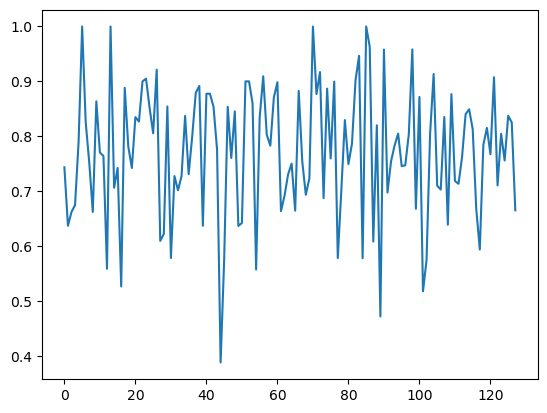

In [15]:
# And the plot
plt.plot(similarity_la)

A mean similarity of around 0.8 for the English - back-tranlsated English is actually not that bad. The variance is quite low at 0.1-ish.

Summa summarum, it appears that the translation is not at all that bad, even if the translated phrases are totally different at first glance.

This explains why the tradition scores turn out to be low, as they don't operate on the semantic level instead on n-grams and character sequences.

Similary, the Latin - translated Latin similarity scores appear to be solid-ish too - assumin this is not entirely just a fluke of the wrong embedding model being used.